In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Portfolio/Projects/Course/Computer-Aided-Diagnosis-GI-Tract-Image-Segmentation')
!pwd

/content/drive/MyDrive/Desktop/4. Spring Course/1. Advances in Computer Vision/7. Project/gi-tract-image-segmentation


In [ ]:
# Unzip files into the On the Fly Dataset
import zipfile
import os

zip_path = '/content/drive/MyDrive/Portfolio/Projects/Course/Computer-Aided-Diagnosis-GI-Tract-Image-Segmentation/datasets/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import animation, rc
import imageio
import time
import cv2
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
from skimage.morphology import label
import random
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import StratifiedKFold
from skimage.segmentation import watershed
from skimage.measure import label
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import random
import pickle
import os
import collections
from sklearn.model_selection import train_test_split
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from tqdm import tqdm
SEED = 42

In [ ]:
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap

In [ ]:
from src.data import SegmentationDataset
from src.data import DataGenerator

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [ ]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1 - dice

def dice_coef_func(y_true, y_pred, smooth=1):
    y_true_f = y_true.contiguous().view(-1)
    y_pred_f = y_pred.contiguous().view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

In [ ]:
train_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='datasets/coco/train_json.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='datasets/coco/val_json.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="test",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='datasets/coco/test_json.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=3.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
loading annotations into memory...
Done (t=1.37s)
creating index...
index created!


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_masks(X, y):
    # Create custom colormaps for the masks
    cmap1 = ListedColormap(['none', 'red'])  # Mask 1 in red
    cmap2 = ListedColormap(['none', 'green'])  # Mask 2 in green
    cmap3 = ListedColormap(['none', 'blue'])  # Mask 3 in blue

    fig, ax = plt.subplots()
    # Display the grayscale image
    ax.imshow((X/255.)[:,:,0], cmap='gray')

    # Display the first mask
    ax.imshow(y[:,:,0], cmap=cmap1, alpha=0.5)

    # Display the second mask
    ax.imshow(y[:,:,1], cmap=cmap2, alpha=0.5)

    # Display the third mask
    ax.imshow(y[:,:,2], cmap=cmap3, alpha=0.5)

    # Create a legend for the masks
    red_patch = mpatches.Patch(color='red', label='Small Bowel')
    green_patch = mpatches.Patch(color='green', label='Large Bowel')
    blue_patch = mpatches.Patch(color='blue', label='Stomach')
    plt.legend(handles=[red_patch, green_patch, blue_patch])

    # Show the plot
    plt.show()

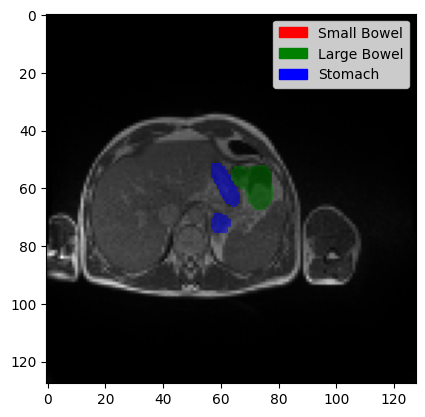

In [ ]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class[0]

plot_masks(X, y)

In [ ]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [ ]:
print("Batch size:", train_loader.batch_size)
print("Num workers:", train_loader.num_workers)
print("Dataset size:", len(train_loader.dataset))
print("Number of batches:", len(train_loader))

Batch size: 32
Num workers: 0
Dataset size: 14269
Number of batches: 446


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(0.1)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU(0.1)
        self._init_weights()

    def forward(self, x):
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.relu2(self.norm2(self.conv2(x)))
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
        self._init_weights()

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

    def _init_weights(self):
        # Initialize weights for the transpose convolution
        nn.init.kaiming_normal_(self.up.weight, mode='fan_out', nonlinearity='relu')
        if self.up.bias is not None:
            nn.init.constant_(self.up.bias, 0)

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.inc = ConvBlock(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        self._init_weights()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return self.sigmoid(logits)

    def _init_weights(self):
        # Initialize weights for the final output convolution
        nn.init.kaiming_normal_(self.outc.weight, mode='fan_out', nonlinearity='relu')
        if self.outc.bias is not None:
            nn.init.constant_(self.outc.bias, 0)


In [ ]:
criterion = DiceLoss().to(device)

In [ ]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)  # Example input
output = model(input)
print(output.shape)  # Should be torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


In [ ]:
data, target = next(iter(train_loader))

In [ ]:
data.permute(0, 3, 1, 2).shape

torch.Size([32, 3, 128, 128])

In [ ]:
data = torch.tensor(train_generator_class[0][0], dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
target = torch.tensor(train_generator_class[0][1], dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)

In [ ]:
model.eval()
output = model(data)

In [ ]:
output.shape

torch.Size([1, 3, 128, 128])

In [ ]:
loss = criterion(output, target)

In [ ]:
loss

tensor(0.9727, grad_fn=<RsubBackward1>)